# Network Topology (Centrality) Analysis

In [1]:
from common_variables import *
DATA['paths']
resave_figures = False

Data loading complete!
Data loaded into DATA dictionary.


In [2]:
statistical_results_TvsN = pd.read_excel('output/sampling_results_differential_rxns.xlsx', sheet_name='Sheet1')

In [3]:
# Load Metabolic Network Function
def loadMetabolicNetworks(directory):
    G_list = []
    G_names = []
    
    # Find all node table files
    node_files = glob.glob(os.path.join(directory, 'NodeTable_*.csv'))
    if not node_files:
        print(f"No node table files found in directory: {directory}")
        return [], [], []
    print(f"Found node table files.\n")
    
    # Load each model
    for node_file in sorted(node_files):
        model_name = re.search(r'NodeTable_(.+)\.csv', node_file).group(1)
        edge_file = os.path.join(directory, f'EdgeTable_{model_name}.csv')

        # Check if edge file exists
        if not os.path.exists(edge_file):
            print(f"Warning: No edge table found for {model_name}")
            continue
        
        node_df = pd.read_csv(node_file)
        edge_df = pd.read_csv(edge_file)

        # Reverse edges where flux is negative
        edge_df['AdjustedSource'] = edge_df.apply(lambda row: row['Target'] if row['Flux'] < 0 else row['Source'], axis=1)
        edge_df['AdjustedTarget'] = edge_df.apply(lambda row: row['Source'] if row['Flux'] < 0 else row['Target'], axis=1)
        edge_df['AdjustedFlux'] = edge_df['Flux'].abs()  # Convert flux to positive after flipping

        # Create a MultiDiGraph to preserve all edges
        G = nx.MultiDiGraph()
        
        # Add nodes with metabolite names as attributes
        for _, row in node_df.iterrows():
            G.add_node(row['NodeID'], MetaboliteID=row['MetaboliteID'], MetaboliteName=row['MetaboliteName'])
        
        # Add edges to the graph, keeping all distinct reactions
        for _, row in edge_df.iterrows():
            G.add_edge(
                row['AdjustedSource'], row['AdjustedTarget'], key=row['ReactionID'],
                ReactionID=row['ReactionID'], 
                ReactionName=row.get('ReactionName', 'Undefined Rxn Name'),
                weight=row['AdjustedFlux']
            )

        G_list.append(G)
        G_names.append(model_name)
        print(f"Loaded model/graph {model_name} with {len(G.nodes)} nodes and {G.number_of_edges()} total edges.")

    return G_list, G_names

G_list, G_names = loadMetabolicNetworks(DATA['paths']['dir_nodesedges']) 
G_names = [name.replace('Cancer_', 'Epithelial_') for name in G_names]


Found node table files.

Loaded model/graph Cancer_Normal_Malignant with 4134 nodes and 40323 total edges.
Loaded model/graph Cancer_Tumor_Malignant with 4143 nodes and 41722 total edges.
Loaded model/graph Fibroblast_Normal_CD73+ with 3740 nodes and 35633 total edges.
Loaded model/graph Fibroblast_Normal_DES+ with 3407 nodes and 32961 total edges.
Loaded model/graph Fibroblast_Normal_FAP+ with 3843 nodes and 36331 total edges.
Loaded model/graph Fibroblast_Normal_FGFR2+ with 3842 nodes and 36185 total edges.
Loaded model/graph Fibroblast_Normal_ICAM1+ with 3729 nodes and 36882 total edges.
Loaded model/graph Fibroblast_Normal_ICAM1- with 3742 nodes and 38461 total edges.
Loaded model/graph Fibroblast_Normal_MFAP5+ with 3717 nodes and 33600 total edges.
Loaded model/graph Fibroblast_Tumor_CD73+ with 3761 nodes and 31701 total edges.
Loaded model/graph Fibroblast_Tumor_DES+ with 3535 nodes and 33331 total edges.
Loaded model/graph Fibroblast_Tumor_FAP+ with 3799 nodes and 39001 total ed

In [4]:
def add_metabolite_ids_to_metrics(G_list, G_names, G_centrality_metrics):
    # Create a copy of the input DataFrame to avoid modifying the original
    result_df = G_centrality_metrics.copy()
    
    # Add empty columns for MetaboliteID and MetaboliteName
    result_df['MetaboliteID'] = None
    result_df['MetaboliteName'] = None
    
    # Create a mapping from graph name to graph object
    graph_dict = dict(zip(G_names, G_list))
    
    # Iterate through each row in the DataFrame
    for idx, row in result_df.iterrows():
        graph_name = row['Graph']
        node = row['Node']
        
        # Get the corresponding graph
        if graph_name in graph_dict:
            G = graph_dict[graph_name]
            
            # Check if the node exists in the graph
            if node in G.nodes:
                # Get node attributes
                node_attrs = G.nodes[node]
                
                # Extract MetaboliteID and MetaboliteName if they exist
                if 'MetaboliteID' in node_attrs:
                    result_df.at[idx, 'MetaboliteID'] = node_attrs['MetaboliteID']
                
                if 'MetaboliteName' in node_attrs:
                    result_df.at[idx, 'MetaboliteName'] = node_attrs['MetaboliteName']
    
    print(f"Added metabolite information to {result_df['MetaboliteID'].notnull().sum()} out of {len(result_df)} rows")
    
    return result_df

def convert_multidigraph_to_digraph(G):
    if not isinstance(G, nx.MultiDiGraph):
        return G  # If it's already a simple graph, return as is

    simple_G = nx.DiGraph()
    for u, v, data in G.edges(data=True):
        weight = data.get("weight", 1.0)
        if simple_G.has_edge(u, v):
            simple_G[u][v]["weight"] += weight  # Sum weights of parallel edges
        else:
            simple_G.add_edge(u, v, weight=weight)
    
    return simple_G


def compute_centrality_measures(G, weight='weight'):
    centrality_metrics = {}
    
    # Skip computation for empty graphs
    if G.number_of_nodes() == 0:
        return centrality_metrics
    
    # Degree Centrality
    centrality_metrics['DegreeCentrality'] = nx.degree_centrality(G)
    
    # In-Degree and Out-Degree Centrality (for directed graphs)
    if G.is_directed():
        centrality_metrics['InDegreeCentrality'] = nx.in_degree_centrality(G)
        centrality_metrics['OutDegreeCentrality'] = nx.out_degree_centrality(G)
    
    # Betweenness Centrality
    try:
        centrality_metrics['BetweennessCentrality'] = nx.betweenness_centrality(G, weight=weight)
    except:
        warnings.warn(f"Could not compute betweenness centrality")
        centrality_metrics['BetweennessCentrality'] = {node: 0 for node in G.nodes()}
    
    # Closeness Centrality
    try:
        centrality_metrics['ClosenessCentrality'] = nx.closeness_centrality(G, distance=weight)
    except:
        warnings.warn(f"Could not compute closeness centrality")
        centrality_metrics['ClosenessCentrality'] = {node: 0 for node in G.nodes()}
    
    # PageRank
    try:
        centrality_metrics['Pagerank'] = nx.pagerank(G, weight=weight)
    except:
        warnings.warn(f"Could not compute pagerank")
        centrality_metrics['Pagerank'] = {node: 0 for node in G.nodes()}
    
    # Convert MultiDiGraph to DiGraph for Load and Eigenvector centrality
    G = convert_multidigraph_to_digraph(G) # Convert MultiDiGraph to a simple DiGraph

    # Load Centrality
    try:
        centrality_metrics['LoadCentrality'] = nx.load_centrality(G, weight=weight)
    except:
        warnings.warn(f"Could not compute load centrality")
        centrality_metrics['LoadCentrality'] = {node: 0 for node in G.nodes()}


    # Eigenvector Centrality    
    if not nx.is_strongly_connected(G):
        largest_scc = max(nx.strongly_connected_components(G), key=len)
        G = G.subgraph(largest_scc).copy()
    try:
        centrality_metrics['EigenvectorCentrality'] = nx.eigenvector_centrality_numpy(G, weight=weight, max_iter=1000)

    except:
        warnings.warn("Could not compute eigenvector centrality")
        centrality_metrics['EigenvectorCentrality'] = {node: 0 for node in G.nodes()}


    return centrality_metrics

def calculate_centrality_stats(centrality_dict):
    if not centrality_dict:
        return {
            'Max': 0,
            'Min': 0,
            'Mean': 0,
            'Median': 0,
            'Std': 0,
            'Skewness': 0,
            'Kurtosis': 0,
            'Gini': 0
        }
    values = list(centrality_dict.values())
    
    # Calculate Gini coefficient (measure of inequality/centralization)
    def gini(arr):
        # Sort array
        sorted_arr = np.sort(arr)
        n = len(arr)
        index = np.arange(1, n + 1)
        return (np.sum((2 * index - n - 1) * sorted_arr)) / (n * np.sum(sorted_arr))
    
    stats = {
        'Max': float(np.max(values)),
        'Min': float(np.min(values)),
        'Mean': float(np.mean(values)),
        'Median': float(np.median(values)),
        'Std': float(np.std(values)),
        'Skewness': float(pd.Series(values).skew()),
        'Kurtosis': float(pd.Series(values).kurtosis()),
        'Gini': float(gini(values))
    }
    
    return stats

def calculate_graph_metrics(G_list, G_names):
    outdata = []
    centrality_data = []  # We'll store all centrality measures here
    
    for G, name in zip(G_list, G_names):
        # Show progress i out of total number
        print(f"Graph {G_list.index(G)+1} of {len(G_list)}: Processing graph {name}")

        # Extract information from the graph name
        name_parts = name.split('_')
        tissue = next((part for part in name_parts if part in ['Normal', 'Tumor']), 'Unknown')
        type_ = next((part for part in name_parts if part in ['Epithelial', 'Fibroblast', 'Macrophage']), 'Unknown')
        marker = name_parts[-1]  # Last part is the celltype

        # Basic Graph Metrics
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = num_edges / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0

        # Degree Metrics (Directed)
        in_degrees = [deg for _, deg in G.in_degree()]
        out_degrees = [deg for _, deg in G.out_degree()]
        total_degrees = [G.in_degree(n) + G.out_degree(n) for n in G.nodes()]
        avg_in_degree = np.mean(in_degrees) if num_nodes > 0 else 0
        avg_out_degree = np.mean(out_degrees) if num_nodes > 0 else 0
        max_in_degree = max(in_degrees) if num_nodes > 0 else 0
        max_out_degree = max(out_degrees) if num_nodes > 0 else 0
        zero_out_degree = sum(1 for deg in out_degrees if deg == 0)
        degree_std = np.std(total_degrees) if num_nodes > 0 else 0
        degree_skewness = float(pd.Series(total_degrees).skew()) if num_nodes > 0 else 0
        degree_kurtosis = float(pd.Series(total_degrees).kurtosis()) if num_nodes > 0 else 0
        degree_heterogeneity = np.mean([d**2 for d in total_degrees]) / (np.mean(total_degrees)**2) if np.mean(total_degrees) > 0 else 0
        degree_centralization = (max(total_degrees) - np.mean(total_degrees)) / (len(total_degrees) - 1) if num_nodes > 1 else 0

        # Weight-based Metrics 
        weights = []
        for u, v, data in G.edges(data=True):
            if 'weight' in data:
                weights.append(data['weight'])
        
        if weights:  # Only calculate if there are edges
            total_weight = sum(weights)
            avg_weight = total_weight / num_edges
            weight_std = float(np.std(weights))
            weight_skewness = float(pd.Series(weights).skew())
            weight_kurtosis = float(pd.Series(weights).kurtosis())
            weight_q1 = float(np.percentile(weights, 25))
            weight_q3 = float(np.percentile(weights, 75))
            weight_iqr = weight_q3 - weight_q1
            weight_range = float(max(weights) - min(weights))
            abs_weights = np.abs(weights)
            mean_absolute_weight = float(np.mean(abs_weights))
            max_absolute_weight = float(np.max(abs_weights))
            mean_weight = np.mean(weights)
            std_weight = np.std(weights)
            weight_median = float(np.median(weights))
            
            # Weight asymmetry (MultiDiGraph compatible)
            weight_asymmetry = 0
            bidirectional_count = 0
            edge_weights = {}
            for u, v, data in G.edges(data=True):
                if 'weight' in data:
                    key = (u, v)
                    if key not in edge_weights:
                        edge_weights[key] = 0
                    edge_weights[key] += data['weight']
            for (u, v), weight in edge_weights.items():
                if (v, u) in edge_weights:
                    weight_asymmetry += abs(weight - edge_weights[(v, u)])
                    bidirectional_count += 1
            
            weight_asymmetry = weight_asymmetry / bidirectional_count if bidirectional_count > 0 else 0
        else:
            print(f"Warning: No weights found in graph {name}.")
            total_weight = avg_weight = weight_std = weight_skewness = weight_kurtosis = 0
            weight_q1 = weight_q3 = weight_iqr = weight_range = 0
            mean_absolute_weight = max_absolute_weight = mean_weight = std_weight = 0
            weight_median = weight_asymmetry = 0

        # Node type classifications
        branch_points = sum(1 for n in G.nodes() if min(G.in_degree(n), G.out_degree(n)) > 1)
        linear_nodes = sum(1 for n in G.nodes() if G.in_degree(n) == 1 and G.out_degree(n) == 1)
        terminal_nodes = sum(1 for n in G.nodes() if G.in_degree(n) * G.out_degree(n) == 0)
        sources = sum(1 for n in G.nodes() if G.in_degree(n) == 0 and G.out_degree(n) > 0)
        sinks = sum(1 for n in G.nodes() if G.in_degree(n) > 0 and G.out_degree(n) == 0)
        
        # Edge type classifications 
        # For bidirectional edges, we need to count unique node pairs
        bidirectional_pairs = set()
        for u, v in G.edges():
            if G.has_edge(v, u) and (v, u) not in bidirectional_pairs:
                bidirectional_pairs.add((u, v))
        bidirectional_edges = len(bidirectional_pairs)
        
        # For high flux edges, check each edge's weight against threshold
        high_flux_edges = sum(1 for _, _, d in G.edges(data=True) 
                            if 'weight' in d and abs(d['weight']) > mean_weight + std_weight) if weights else 0
                            
        # Flux balance metrics
        flux_balances = {}
        for node in G.nodes():
            # Sum weights of all incoming edges
            in_flux = 0
            for pred in G.predecessors(node):
                for edge_data in G.get_edge_data(pred, node).values():

                    # Check if the node has one or multiple edges   
                    if isinstance(G, nx.MultiDiGraph):
                        for key, data in G[pred][node].items():
                            if 'weight' in data:
                                in_flux += data['weight']
                    else:
                        edge_data = G[pred][node]
                        # Check if the edge has a weight attribute
                        if 'weight' in edge_data:
                            in_flux += edge_data['weight']
            
            # Sum weights of all outgoing edges
            out_flux = 0
            for succ in G.successors(node):
                for edge_data in G.get_edge_data(node, succ).values():

                    # Check if the node has one or multiple edges   
                    if isinstance(G, nx.MultiDiGraph):
                        for key, data in G[node][succ].items():
                            if 'weight' in data:
                                out_flux += data['weight']
                    else:
                        edge_data = G[node][succ]
                        # Check if the edge has a weight attribute
                        if 'weight' in edge_data:
                            out_flux += edge_data['weight']
                        
            flux_balances[node] = abs(in_flux - out_flux)

        if flux_balances:
            mean_flux_imbalance = float(np.mean(list(flux_balances.values())))
            max_flux_imbalance = float(max(flux_balances.values()))
            balanced_nodes = sum(1 for v in flux_balances.values() if v < 1e-10)
            flux_balance_ratio = balanced_nodes / len(flux_balances)
        else:
            mean_flux_imbalance = max_flux_imbalance = balanced_nodes = flux_balance_ratio = 0

        # Calculate all centrality measures
        centrality_measures = compute_centrality_measures(G, weight='weight')
        
        # Calculate statistics for each centrality measure
        centrality_stats = {}
        for measure_name, measure_values in centrality_measures.items():
            stats = calculate_centrality_stats(measure_values)
            for stat_name, stat_value in stats.items():
                centrality_stats[f"{measure_name}{stat_name}"] = stat_value
        
        # Store the node-level centrality data for further analysis
        for node in G.nodes():
            node_centrality = {
                'Graph': name,
                'Tissue': tissue,
                'Type': type_,
                'Marker': marker,
                'Node': node
            }
            
            # Add each centrality measure for this node
            for measure_name, measure_values in centrality_measures.items():
                node_centrality[measure_name] = measure_values.get(node, 0)
                
            centrality_data.append(node_centrality)
        
        # Create a dictionary for this graph's metrics
        graph_metrics = {
            'Name': name,
            'Tissue': tissue,
            'Type': type_,
            'Marker': marker,
            'Nodes': num_nodes,
            'Edges': num_edges,
            'Density': density,
            'TotalWeight': total_weight,
            'AvgWeight': avg_weight,
            'AvgInDegree': avg_in_degree,
            'AvgOutDegree': avg_out_degree,
            'MaxInDegree': max_in_degree,
            'MaxOutDegree': max_out_degree,
            'ZeroOutDegreeCount': zero_out_degree,
            'DegreeCentralization': degree_centralization,
            'DegreeStd': degree_std,
            'DegreeSkewness': degree_skewness,
            'DegreeKurtosis': degree_kurtosis,
            'DegreeHeterogeneity': degree_heterogeneity,
            'WeightStd': weight_std,
            'MeanAbsoluteWeight': mean_absolute_weight,
            'MaxAbsoluteWeight': max_absolute_weight,
            'WeightSkewness': weight_skewness,
            'WeightKurtosis': weight_kurtosis,
            'WeightQ1': weight_q1,
            'WeightQ3': weight_q3,
            'WeightRange': weight_range,
            'WeightIQR': weight_iqr,
            'WeightMedian': weight_median,
            'WeightAsymmetry': weight_asymmetry,
            'BranchPoints': branch_points,
            'LinearNodes': linear_nodes,
            'TerminalNodes': terminal_nodes,
            'Sources': sources,
            'Sinks': sinks,
            'BidirectionalEdges': bidirectional_edges,
            'HighFluxEdges': high_flux_edges,
            'MeanFluxImbalance': mean_flux_imbalance,
            'MaxFluxImbalance': max_flux_imbalance,
            'BalancedNodes': balanced_nodes,
            'FluxBalanceRatio': flux_balance_ratio,
        }
        
        # Add all the centrality statistics to the graph metrics
        graph_metrics.update(centrality_stats)
        
        # Append to output list
        outdata.append(graph_metrics)
    
    # Create DataFrames
    graph_df = pd.DataFrame(outdata)
    centrality_df = pd.DataFrame(centrality_data)
    centrality_df = add_metabolite_ids_to_metrics(G_list, G_names, centrality_df)
    
    return graph_df, centrality_df

def save_metrics(graph_df, centrality_df, prefix='graph_metrics'):
    graph_df.to_csv(f"{prefix}_network_metrics.csv", index=False)
    print(f"Saved graph metrics to {prefix}_network_metrics.csv")

    centrality_df.to_csv(f"{prefix}_individiual_node_centralities_manuscript.csv", index=False)
    print(f"Saved node centrality measures to {prefix}_individiual_node_centralities.csv")

# Caclculate Graph Metrics and Save -- COMMENTED OUT TO LOAD PREVIOUSLY SAVED METRICS
#G_network_metrics, G_centrality_metrics = calculate_graph_metrics(G_list, G_names) 

# save_metrics(G_network_metrics, G_centrality_metrics, prefix='output/graph_topology')# Load graph metrics

# Load previously saved metrics
G_network_metrics = pd.read_csv('output/graph_topology_network_metrics.csv')
G_network_metrics = G_network_metrics[~G_network_metrics['Name'].str.contains('DES+|MFAP5+')] # remove myofibroblasts

G_centrality_metrics = pd.read_csv('output/graph_topology_individiual_node_centralities.csv')
G_centrality_metrics = G_centrality_metrics.loc[:, (G_centrality_metrics != 0).any(axis=0)]
G_centrality_metrics = G_centrality_metrics[~G_centrality_metrics['Marker'].isin(['DES+', 'MFAP5+'])].copy()# remove myofibroblasts


##### **(A)** Network size comparison showing number of nodes (metabolites) versus edges (reactions) for each cell type-specific model.

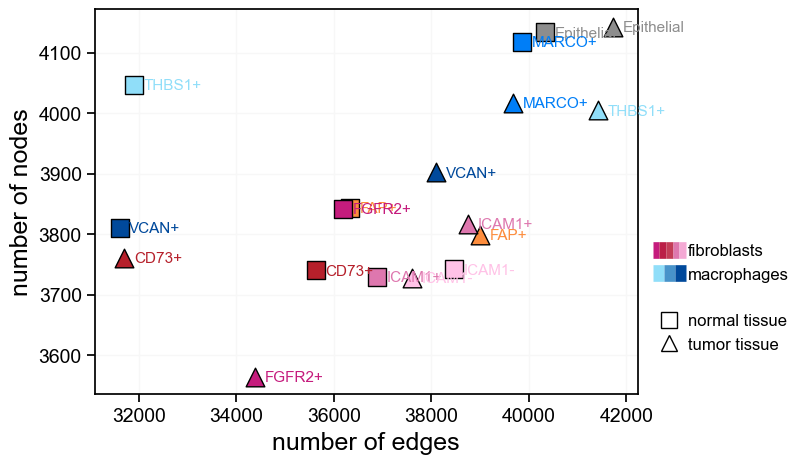

In [5]:
def plot_graph_sizes(df, marker_colors, figsize=(8, 6)):
    # Set up the plot
    df = df[~df['Name'].str.contains('DES|MFAP')] # remove myofibroblasts
    
    fig = plt.figure(figsize=figsize)
    
    # Plot the scatter points
    for _, row in df.iterrows():
        marker = row['Marker']
        shape = row['Tissue']
        plt.scatter(row['Edges'], row['Nodes'], 
                    color=  marker_colors.get(marker, 'black'), 
                    marker = '^' if shape == 'Tumor' else 's',
                    s=180,
                    linewidths=1,
                    edgecolor='black',)
        
        # Add celltype labels next to each point
        if marker == 'Malignant': marker = 'Epithelial'
        plt.text(row['Edges']+200, row['Nodes']-1, marker, fontsize=11, ha='left', va='center', color= marker_colors.get(marker, 'black'))
    
    # Set plot labels and title
    plt.xlabel('number of edges')
    plt.ylabel('number of nodes')

    # Create legend
    class GradientLine:
        pass

    # Create legend elements
    fib_line = GradientLine()
    mac_line = GradientLine()
    legend_elements = [
        fib_line,  # will be replaced by gradient
        mac_line,  # will be replaced by gradient
        Line2D([0], [0], marker=None, color=None, linewidth=0),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='w',  markersize=12, markeredgecolor='black'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor='w',   markersize=12, markeredgecolor='black'),
    ]
    legend_labels = ['fibroblasts','macrophages', '', 'normal tissue', 'tumor tissue']
    
    # Get colors for gradients
    fib_colors = [marker_colors[m] for m in markers_F]
    mac_colors = [marker_colors[m] for m in markers_M]
    
    # Create handler map
    handler_map = { fib_line: GradientLineHandler(fib_colors, n_segments=len(fib_colors)+1),
                    mac_line: GradientLineHandler(mac_colors, n_segments=len(mac_colors)+1) }
    
    # Add legend to axis
    plt.legend(legend_elements, legend_labels,
                    handler_map=handler_map,
                    bbox_to_anchor=(1, 0.43),
                    loc='upper left',
                    frameon=False,
                    fontsize=12,
                    handletextpad=0.1, 
                    alignment='left',
                    ncol=1)
    
    # Show the plot
    if resave_figures: save_figure(fig, 'figure4a_scatter_plot_graph_sizes')
 
    plt.show()
    return fig


fig3a = plot_graph_sizes(G_network_metrics, marker_colors, figsize=(7, 5))


##### **(B)** Network properties showing density, average weight, degree heterogeneity, maximum PageRank, high-flux edges, and balanced nodes proportion.

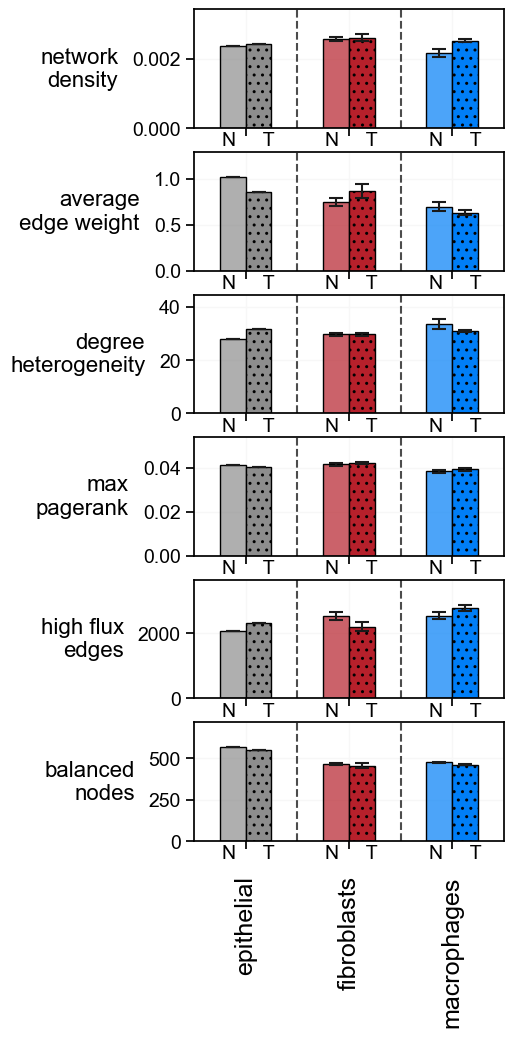

Figure saved: figure4b_network_properties


In [ ]:

def plot_network_metric_comparison_by_celltype_groups(graph_df, metrics, marker_colors=None,
                                                     figsize=(14, 6), dashed_line_positions=None):
    
    # If metrics is a string, convert to list for backward compatibility
    if isinstance(metrics, str):
        metrics = [metrics]
    
    # Calculate figure height based on number of metrics
    n_metrics = len(metrics)
    fig_height = figsize[1] * n_metrics
    
    # Create subplots - one row per metric
    fig, axes = plt.subplots(n_metrics, 1, figsize=(figsize[0], fig_height))
    
    # Handle case where we only have one metric (axes won't be a list)
    if n_metrics == 1:
        axes = [axes]
    
    # Parse the Name column to extract cell type, tissue, and marker
    def parse_name(name):
        parts = name.split('_')
        if len(parts) >= 3:
            cell_type = parts[0]
            tissue = parts[1]
            marker = '_'.join(parts[2:])  # In case marker has underscores
            return cell_type, tissue, marker
        return None, None, None
    
    # Add parsed columns to dataframe
    graph_df_parsed = graph_df.copy()
    parsed_data = graph_df_parsed['Name'].apply(parse_name)
    graph_df_parsed['CellType'] = [x[0] for x in parsed_data]
    graph_df_parsed['Tissue'] = [x[1] for x in parsed_data]
    graph_df_parsed['Marker'] = [x[2] for x in parsed_data]
    
    # Define cell type groups
    cell_type_groups = {
        'epithelial': ['Epithelial'],
        'fibroblasts': ['Fibroblast'],
        'macrophages': ['Macrophage']
    }
    
    # Loop through each metric
    for metric_idx, metric in enumerate(metrics):
        ax = axes[metric_idx]
        
        # Prepare data for plotting
        x_positions = []
        normal_means = []
        normal_errors = []
        tumor_means = []
        tumor_errors = []
        colors_list = []
        group_labels = []
        
        width = 0.25
        
        for i, (group_name, cell_types) in enumerate(cell_type_groups.items()):
            # Get data for this cell type group
            group_data = graph_df_parsed[graph_df_parsed['CellType'].isin(cell_types)]
            
            if len(group_data) > 0:
                # Calculate statistics for Normal tissue
                normal_data = group_data[group_data['Tissue'] == 'Normal'][metric]
                tumor_data = group_data[group_data['Tissue'] == 'Tumor'][metric]
                
                # Remove NaN values
                normal_data = normal_data.dropna()
                tumor_data = tumor_data.dropna()
                
                # Calculate means and standard errors
                if len(normal_data) > 0:
                    normal_mean = normal_data.mean()
                    normal_se = stats.sem(normal_data) if len(normal_data) > 1 else 0
                else:
                    normal_mean, normal_se = 0, 0
                
                if len(tumor_data) > 0:
                    tumor_mean = tumor_data.mean()
                    tumor_se = stats.sem(tumor_data) if len(tumor_data) > 1 else 0
                else:
                    tumor_mean, tumor_se = 0, 0
                
                x_positions.append(i)
                normal_means.append(normal_mean)
                normal_errors.append(normal_se)
                tumor_means.append(tumor_mean)
                tumor_errors.append(tumor_se)
                colors_list.append(marker_colors.get(group_name, 'gray'))
                group_labels.append(group_name)
        
        x_pos = np.array(x_positions)
        
        # Create bars with error bars
        bars1 = ax.bar(x_pos - width/2, normal_means, width,
                       yerr=normal_errors,
                       label='Normal' if metric_idx == 0 else "",
                       color=[plt.matplotlib.colors.to_rgba(c, alpha=0.7) for c in colors_list],
                       edgecolor='black', linewidth=1,
                       capsize=5, error_kw={'elinewidth': 1.5, 'capthick': 1.5})
        
        bars2 = ax.bar(x_pos + width/2, tumor_means, width,
                       yerr=tumor_errors,
                       label='Tumor' if metric_idx == 0 else "",
                       hatch='..',
                       color=colors_list,
                       edgecolor='black', linewidth=1,
                       capsize=5, error_kw={'elinewidth': 1.5, 'capthick': 1.5})
        
        # Add dashed lines to separate conditions if specified
        if dashed_line_positions:
            y_max = max(max(np.array(normal_means) + np.array(normal_errors)), 
                       max(np.array(tumor_means) + np.array(tumor_errors))) * 1.15
            for pos in dashed_line_positions:
                ax.axvline(x=pos, color='black', linestyle='--', alpha=0.7, linewidth=1.5)
        
        # Customize the plot
        y_max = max(max(np.array(normal_means) + np.array(normal_errors)), 
                   max(np.array(tumor_means) + np.array(tumor_errors))) * 1.15
        ax.set_ylim(0, y_max+y_max*0.10)


        # Add N T labels
        for i, bar in enumerate(bars1):  # Normal bars
            x = bar.get_x() + bar.get_width() / 2
            y = 0 - y_max * 0.2  # Slightly above the x-axis baseline (adjust offset)
            ax.text(x+0.15, y, 'N     T', ha='center', va='bottom', fontsize=14)
 
        # Create ylabel with metric, rotate by 90 degrees
        metric = metric.lower()
        if metric == 'density': metric = 'network\ndensity'
        if metric == 'avgweight': metric = 'average\nedge weight'
        if metric == 'degreeheterogeneity': metric = 'degree\nheterogeneity'
        if metric == 'pagerankmax': metric = 'max\nPageRank'
        if metric == 'highfluxedges': metric = 'high flux\nedges'
        if metric == 'totalweight': metric = 'total\nweight'
        if metric == 'balancednodes': metric = 'balanced\nnodes'
        ax.set_ylabel(f'{metric.lower()}', rotation=0, labelpad=10, ha='right', va='center', fontsize=16)

        # Get current y-tick labels and change avgweight to Av
        # Set x-axis - only show labels on bottom subplot
        if metric_idx == len(metrics) - 1:  # Last subplot
            ax.set_xticks(x_pos)
            ax.set_xticklabels(group_labels, y=-.18, fontsize=18, rotation=90)
        else:
            ax.set_xticks(x_pos)
            ax.set_xticklabels([])  # No labels for upper subplots
        
        # set xlim to + - 0.5
        ax.set_xlim(-0.5, len(cell_type_groups) - 0.5)
        ax.tick_params(axis='y')
        
        # Add grid for better readability
        ax.grid(True)
        
    
    # Show the plot
    plt.show()
    
    if resave_figures: save_figure(fig, 'figure4b_network_properties')
    
    return fig


celltype_colors = {
    'epithelial': '#8d8d8d',      # Red
    'fibroblasts': '#b6202b',    # Green
    'macrophages': '#007ef7'     # Blue
}

fig3b = plot_network_metric_comparison_by_celltype_groups(graph_df=G_network_metrics,
                                                            figsize=(4, 1.8),
                                                            metrics=['Density', 'AvgWeight', 'DegreeHeterogeneity', 'PagerankMax', 'HighFluxEdges', 'BalancedNodes'],  # List of metrics
                                                            marker_colors=celltype_colors,
                                                            dashed_line_positions=[0.5, 1.5]  # Lines between the three groups
                                                        )

##### **(C)** Dendrogram of 101 calculated topological metrics, highlighting 16 independent features (shown in black), with correlation matrix of final features confirming independence.

In [7]:
 
def select_clustering_features(df, correlation_threshold=0.8):
    # Select numerical features and remove missing values
    numeric_df = df.select_dtypes(include=[np.number]).dropna(axis=1)
    print(f"Starting with {len(numeric_df.columns)} numerical features")

    # Remove low variance features
    selector = VarianceThreshold(threshold=0.1)
    high_var_df = numeric_df[numeric_df.columns[selector.fit(numeric_df).get_support()]]
    print(f"After variance filtering: {len(high_var_df.columns)} features")

    # Remove highly correlated features
    corr = high_var_df.corr().abs()
    to_drop = set()
    for i in range(len(corr.columns)):
        for j in range(i+1, len(corr.columns)):
            if (
                corr.iloc[i, j] > correlation_threshold
                and corr.columns[i] not in to_drop
                and corr.columns[j] not in to_drop
            ):
                # Drop feature with higher average correlation
                to_drop.add(
                    corr.columns[i]
                    if corr[corr.columns[i]].mean() > corr[corr.columns[j]].mean()
                    else corr.columns[j]
                )
    selected_cols = [c for c in high_var_df.columns if c not in to_drop]
    print(f"After correlation filtering: {len(selected_cols)} features")
    print("Retained features:", selected_cols)
    return selected_cols


# Remove rows with "Malignant" in the Marker column (keeping only F and M)
G_metrics_FM = G_network_metrics[~G_network_metrics['Marker'].str.contains('Malignant')]

# Select optimal clustering features
selected_cols = select_clustering_features(G_metrics_FM, correlation_threshold=0.8)
G_metrics_filtered = G_metrics_FM[['Name','Tissue','Type','Marker'] + selected_cols].copy()

Starting with 101 numerical features
After variance filtering: 45 features
After correlation filtering: 16 features
Retained features: ['Edges', 'TotalWeight', 'DegreeHeterogeneity', 'WeightKurtosis', 'BranchPoints', 'LinearNodes', 'Sources', 'BidirectionalEdges', 'HighFluxEdges', 'BalancedNodes', 'OutDegreeCentralityKurtosis', 'BetweennessCentralitySkewness', 'ClosenessCentralitySkewness', 'PagerankKurtosis', 'LoadCentralityKurtosis', 'EigenvectorCentralitySkewness']


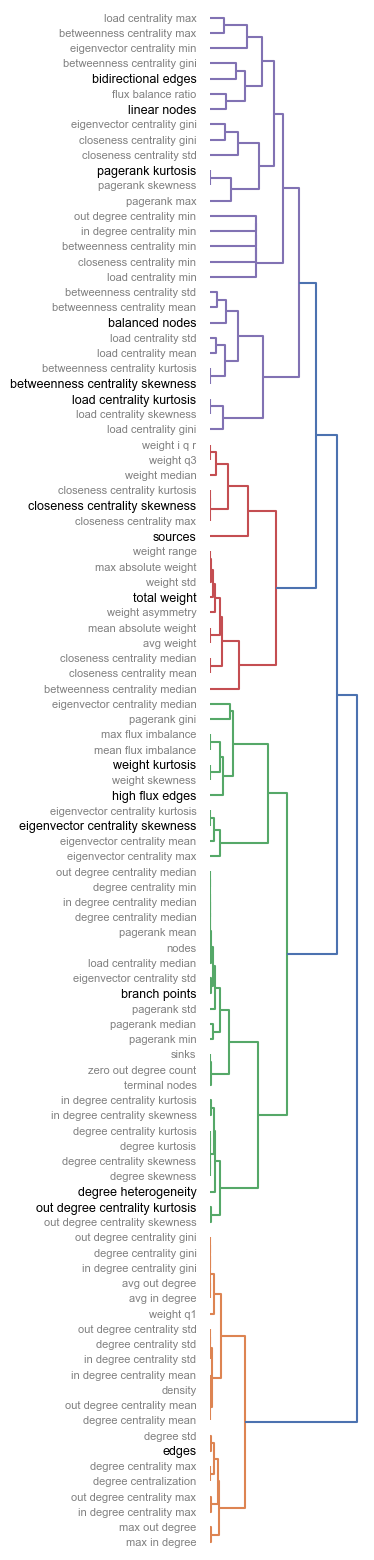

In [8]:
def plotClusteringDendrogram(df, selected_cols, figsize=(4, 13)):   # swapped dimensions
    numeric_df = df.select_dtypes(include=[np.number]).dropna(axis=1)
    corr_matrix = numeric_df.corr().abs()
    corr_matrix = corr_matrix.fillna(0)
    np.fill_diagonal(corr_matrix.values, 1)
    distance_matrix = 1 - corr_matrix
    distance_matrix = np.clip(distance_matrix, 0, 2)
    linkage_matrix = ward(squareform(distance_matrix.values, checks=False))

    fig = plt.figure(figsize=figsize)
    dendrogram(
        linkage_matrix,
        labels=numeric_df.columns.tolist(),
        orientation='right',
        leaf_rotation=0 
    )
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)
        
    # Get and modify tick label texts
    formatted_selected = [re.sub(r'(?<!^)(?=[A-Z])', ' ', col).lower() for col in selected_cols]
    # Get and modify tick label texts
    new_labels = []
    for label in ax.get_yticklabels():
        new_label = re.sub(r'(?<!^)(?=[A-Z])', ' ', str(label.get_text())).lower()
        new_labels.append(new_label)

    # Set the new y-tick labels
    ax.set_yticklabels(new_labels, fontsize=8)

    # Color and size formatting
    for label in ax.get_yticklabels():
        if label.get_text() in formatted_selected:
            label.set_color('black')
            label.set_fontsize(9)
        else:
            label.set_color('gray')

    ax.set_xticks([])
    plt.grid(False)
    plt.show()
    
    if resave_figures: save_figure(fig, 'figure4c_graph_metrics_dendrogram')
    
    return fig

# Usage:
fig3c = plotClusteringDendrogram(G_metrics_FM, selected_cols, figsize=(2, 20))


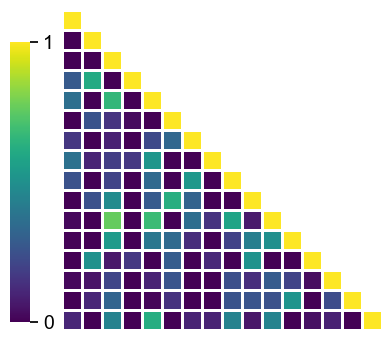

In [9]:

def plotFeatureCorrHeatmap(df, selected_cols):
    # Restrict to numerical columns, with selected columns only
    high_var_df = df.select_dtypes(include=[np.number]).dropna(axis=1)[selected_cols]
    selected_corr = high_var_df.corr()
    
    fig = plt.figure(figsize=(4, 4))  # Larger figure for clarity

    # Manually set the colorbar axis: [left, bottom, width, height]
    cbar_ax = fig.add_axes([0.07, 0.12, 0.05, 0.7])  # Adjust width (0.05) and height (0.5) as needed
    
    # Manually set the heatmap axis (to the right of the colorbar)
    heatmap_ax = fig.add_axes([0.2, 0.1, 0.8, 0.8])  # [left, bottom, width, height] for main plot

    # Plot heatmap
    sns.heatmap(
        selected_corr,
        mask=np.triu(np.ones_like(selected_corr, dtype=bool), k=1),
        cmap='viridis', vmax=1, vmin=0, square=True, linewidths=1, linecolor='white',
        ax=heatmap_ax,
        cbar_ax=cbar_ax,
        cbar_kws={"ticks": [0, 1]}  # Show only ticks at 0 and 1
    )

    # Customize colorbar tick labels if desired
    cbar_ax.set_yticklabels(['0', '1'])

    # Remove ticks/grid from heatmap
    heatmap_ax.set_xticks([])
    heatmap_ax.set_yticks([])
    heatmap_ax.tick_params(right=True, bottom=True, left=False, top=False)
    heatmap_ax.grid(False)
    
    plt.show()
    if resave_figures: save_figure(fig, 'figure4c_graph_metrics_dendrogram_correlation')

    return fig

fig3c = plotFeatureCorrHeatmap(G_metrics_FM, selected_cols)


##### **(D)** K-means clustering of networks using independent topological features, with silhouette and inertia analysis shown confirming optimal cluster number of 4.

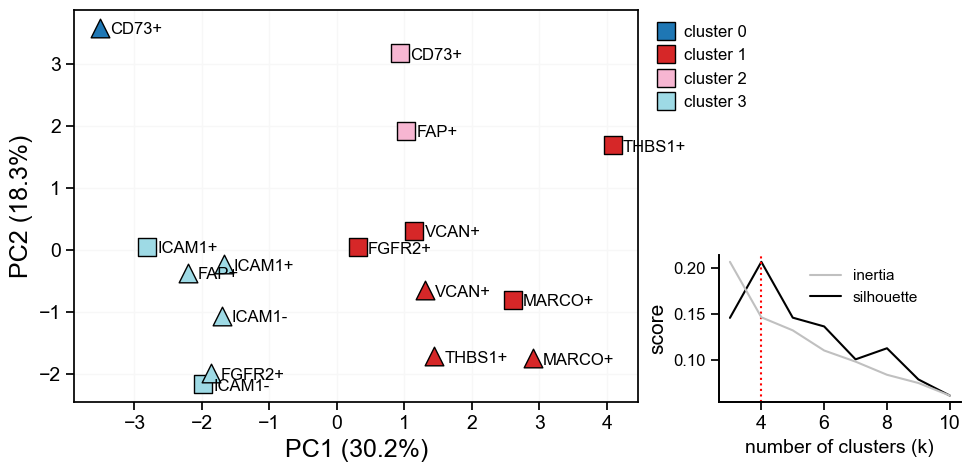

In [10]:
def clusterMarkersByMetrics(G_metrics, max_clusters=10, force_k=None, show_eval_metrics=False, figsize=(12, 7)):
    # Select numeric columns
    numeric_columns = G_metrics.select_dtypes(include=[np.number]).columns.tolist()
    
    # Create marker mapping
    tissue_shapes = {'Normal': 's', 'Tumor': '^'}
    markers = G_metrics['Tissue'].map(tissue_shapes)
    
    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(G_metrics[numeric_columns])
    
    # Calculate both silhouette scores and inertia (for elbow method)
    silhouette_scores = []
    inertias = []
    
    for k in range(3, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
        inertias.append(kmeans.inertia_)
    
    # Choose optimal number of clusters (highest silhouette score)
    if force_k: # Force a specific number of clusters
        optimal_clusters = force_k  # Use forced value  
    else:   
        optimal_clusters = np.argmax(silhouette_scores) + 3
    
    # Perform final clustering with optimal number of clusters
    final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    labels = final_kmeans.fit_predict(X)
    
    # PCA reduction
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    var_explained = pca.explained_variance_ratio_ * 100
    
    # Create a new figure with a grid layout - using GridSpec for more control
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2, width_ratios=[7, 3], height_ratios=[1, .6])
    
    # PCA plot on the left taking 70% of width and full height
    ax_pca = fig.add_subplot(gs[:, 0])  # Spans both rows in first column
    
    # Generate distinct colors for clusters
    cluster_colors = plt.cm.tab20(np.linspace(0, 1, optimal_clusters))
    
    # Create scatter plot with cluster colors and tissue markers in the PCA subplot
    for i in range(len(G_metrics)):
        # Get marker for current tissue type
        marker = markers.iloc[i]
        
        # Create label with marker info
        cell_types = set(G_metrics['Type'].unique())
        if len(cell_types) > 1:
            cell_label = f"{G_metrics['Marker'].iloc[i]}"
        else:
            cell_label = f"{G_metrics['Marker'].iloc[i]}"
        
        # Plot point with cluster color
        ax_pca.scatter(X_reduced[i, 0],
                   X_reduced[i, 1],
                   c=[cluster_colors[labels[i]]],
                   marker=marker,
                   linewidths=1,
                   edgecolors='black',
                   s=180)
        
        # Add labels
        ax_pca.text(X_reduced[i, 0] + 0.15,
                    X_reduced[i, 1] - 0.03,
                    cell_label,
                    fontsize=12,
                    ha='left',
                    va='center')
    
    # Customize PCA plot
    ax_pca.set_xlabel(f'PC1 ({var_explained[0]:.1f}%)')
    ax_pca.set_ylabel(f'PC2 ({var_explained[1]:.1f}%)')
    ax_pca.set_title('')
    
    # Legend at the top right
    ax_legend = fig.add_subplot(gs[0, 1])
    ax_legend.axis('off')  # Hide the axis for the legend
    
    # Create legend elements - with no lines, only markers
    # Cluster legends
    cluster_legend_elements = [
        plt.Line2D([0], [0], marker='s', color='black', markerfacecolor=cluster_colors[i], 
                  label=f'cluster {i}', markersize=13, linestyle='None')
        for i in range(optimal_clusters)
    ]
    
    # Tissue type legends
    tissue_legend_elements = [
        plt.Line2D([0], [0], marker='s', color='black', markerfacecolor='white', 
                  label='normal tissue', markersize=12, linestyle='None'),
        plt.Line2D([0], [0], marker='^', color='black', markerfacecolor='white', 
                  label='tumor tissue', markersize=15, linestyle='None')
    ]
    
    # Combine all legend elements (clusters + tissue types)
    spacer = [plt.Line2D([0], [0], linestyle='None', label='', color='none')]
    combined_legend_elements =  tissue_legend_elements + spacer + cluster_legend_elements

    # Create a single legend with all elements in one column
    ax_legend.legend(handles=cluster_legend_elements,
                    bbox_to_anchor=(-.35, 1),  # Specify position as (x, y)
                    loc='upper left',        # Anchor point of legend box
                    fontsize=12,
                    handletextpad=0.1, 
                    frameon=False,
                    ncol=1)  # Ensures one column
    
    if show_eval_metrics:
        # Create a subplot for evaluation metrics (bottom right)
        ax_eval = fig.add_subplot(gs[1, 1])
        
        # Remove grid from the evaluation metrics subplot only
        ax_eval.grid(False)
        
        # Two y-axes for silhouette and inertia
        ax_silhouette = ax_eval
        ax_inertia = ax_eval.twinx()
        
        # Plot silhouette scores
        line1 = ax_silhouette.plot(range(3, max_clusters + 1), silhouette_scores, '-', color='black', label='silhouette')
        ax_silhouette.set_xlabel('number of clusters (k)', fontsize=14)
        ax_silhouette.set_ylabel('score', color='black', fontsize=15)
        ax_silhouette.tick_params(axis='y', labelcolor='black', labelsize=12)
        ax_silhouette.tick_params(axis='x')
        
        # Plot inertia (elbow method)
        line2 = ax_inertia.plot(range(3, max_clusters + 1), inertias, '-', color='silver', label='inertia')
        #ax_inertia.set_ylabel('inertia', color='silver', fontsize=16)
        ax_inertia.set_yticks([])

        ax_inertia.grid(False)
        
        # Add vertical line to indicate chosen k
        ax_eval.axvline(x=optimal_clusters, color='red', linestyle=':', alpha=1, 
                        label=f'Selected k={optimal_clusters}')
        
        ax_eval.spines['top'].set_visible(False)
        ax_eval.spines['right'].set_visible(False)
        ax_silhouette.spines['top'].set_visible(False)
        ax_silhouette.spines['right'].set_visible(False)
        ax_inertia.spines['top'].set_visible(False)
        ax_inertia.spines['right'].set_visible(False)
        
        # Combine legends from both y-axes - with markers only (no lines)
        lines = line2 + line1 
        figlabels = [l.get_label() for l in lines]
        ax_eval.legend(lines, figlabels, loc='upper center', bbox_to_anchor=(0.6, 1), frameon=False)  
        ax_eval.set_title('')
    
    plt.tight_layout()
    fig.subplots_adjust(hspace=0, wspace=0.2)  # Adjust spacing
    
    plt.show()
    if resave_figures: save_figure(fig, 'figure4d_graph_metrics_clustering')
    
    return fig
     

fig3d = clusterMarkersByMetrics(G_metrics_filtered, force_k=None, show_eval_metrics=True, figsize=[10, 5])

##### **(E)** Metabolite centrality rank difference heatmaps for FAP+ fibroblasts (left) and MARCO+ macrophages (right). Top panels show tumor versus normal tissue comparisons identifying tumor-specific metabolic adaptations. Bottom panels show comparisons against other cell types within the same lineage in tumor tissue. Positive values (red) indicate increased centrality in the target population, negative values (blue) indicate decreased centrality.

In [11]:
def compareCentralitiesPerMarker(G_centrality_metrics, target_marker, all_markers):
    centrality_measures = (G_centrality_metrics
                          .select_dtypes(include=[np.number])
                          .drop(columns=['Node', 'InDegreeCentrality', 'OutDegreeCentrality'])
                          .columns.tolist())
    
    # Part 1: Target marker vs all other markers in tumor tissue
    tumor_data = G_centrality_metrics[G_centrality_metrics['Tissue'] == 'Tumor'].copy()
    rank_data = pd.DataFrame()
    
    for marker in all_markers:
        marker_data = tumor_data[tumor_data['Marker'] == marker].copy()
        if len(marker_data) == 0:
            continue
            
        for measure in centrality_measures:
            marker_data.loc[:, f'{measure}_rank'] = marker_data[measure].rank(pct=True) * 100
            
        columns_to_keep = ['MetaboliteID', 'MetaboliteName', 'Marker'] + [f'{m}_rank' for m in centrality_measures]
        marker_data = marker_data[columns_to_keep]
        rank_data = pd.concat([rank_data, marker_data])
    
    met_names = rank_data[['MetaboliteID', 'MetaboliteName']].drop_duplicates().set_index('MetaboliteID')
    target_ranks = rank_data[rank_data['Marker'] == target_marker].drop(columns=['Marker']).set_index('MetaboliteID')
    
    other_markers = [m for m in all_markers if m != target_marker]
    other_ranks = (rank_data[rank_data['Marker'].isin(other_markers)]
                   .drop(columns=['Marker', 'MetaboliteName'])
                   .groupby('MetaboliteID').mean(numeric_only=True))
    
    comparison = (target_ranks.merge(other_ranks, left_index=True, right_index=True,
                                     suffixes=(f'_{target_marker}', '_others'))
                  .merge(met_names, left_index=True, right_index=True)
                  .reset_index())
    
    for measure in centrality_measures:
        comparison[f'{measure}_rank_diff'] = (comparison[f'{measure}_rank_{target_marker}'] - 
                                             comparison[f'{measure}_rank_others'])
    
    if 'MetaboliteName_x' in comparison.columns:
        comparison = comparison.rename(columns={'MetaboliteName_x': 'MetaboliteName'})
    
    # Part 2: Target marker in tumor vs normal tissue
    marker_normal = G_centrality_metrics[(G_centrality_metrics['Marker'] == target_marker) &
                                         (G_centrality_metrics['Tissue'] == 'Normal')].copy()
    marker_tumor = G_centrality_metrics[(G_centrality_metrics['Marker'] == target_marker) &
                                        (G_centrality_metrics['Tissue'] == 'Tumor')].copy()
    
    common_mets = set(marker_normal['MetaboliteID']).intersection(set(marker_tumor['MetaboliteID']))
    
    for measure in centrality_measures:
        marker_normal.loc[:, f'{measure}_rank'] = marker_normal[measure].rank(pct=True) * 100
        marker_tumor.loc[:, f'{measure}_rank'] = marker_tumor[measure].rank(pct=True) * 100
    
    tissue_results = []
    for met_id in common_mets:
        normal_row = marker_normal[marker_normal['MetaboliteID'] == met_id].iloc[0]
        tumor_row = marker_tumor[marker_tumor['MetaboliteID'] == met_id].iloc[0]
        
        result = {'MetaboliteID': met_id, 'MetaboliteName': normal_row['MetaboliteName']}
        
        for measure in centrality_measures:
            normal_val, tumor_val = normal_row[measure], tumor_row[measure]
            normal_rank, tumor_rank = normal_row[f'{measure}_rank'], tumor_row[f'{measure}_rank']
            if normal_val <= 0 or tumor_val <= 0:
                log2fc = np.nan
            else:
                log2fc = np.log2(tumor_val / normal_val)
                
            result[f'{measure}_log2fc'] = log2fc
            result[f'{measure}_rank_diff'] = tumor_rank - normal_rank
        
        result['average_log2fc'] = np.nanmean([result[f'{measure}_log2fc'] for measure in centrality_measures])
        result['average_rank_diff'] = np.nanmean([result[f'{measure}_rank_diff'] for measure in centrality_measures])
        tissue_results.append(result)
    
    tissue_comparison = pd.DataFrame(tissue_results)
    return comparison, tissue_comparison

centralities_FAP_TvsAll, centralities_FAP_TvsN = compareCentralitiesPerMarker(G_centrality_metrics, 'FAP+', markers_F)
centralities_MARCO_TvsAll, centralities_MARCO_TvsN = compareCentralitiesPerMarker(G_centrality_metrics, 'MARCO+', markers_M)


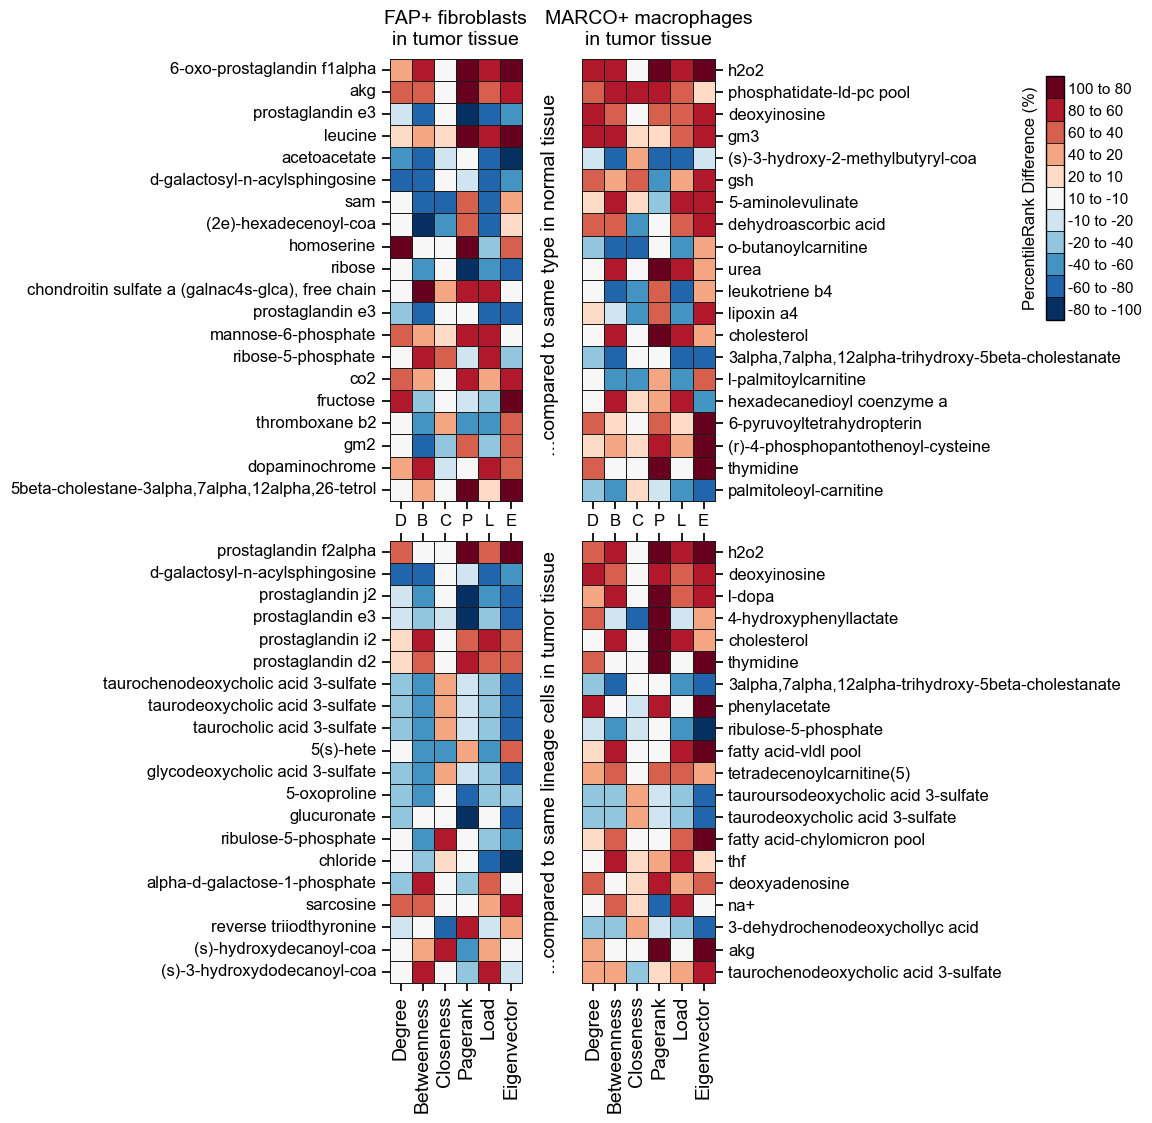

Figure saved: figure4e_metabolite_rank_diff


In [12]:
def createMarkerMetaboliteHeatmap(topleft, topleft_title,
                                 topright, topright_title,
                                 topmiddle_text,
                                 bottomleft, bottomleft_title,
                                 bottomright, bottomright_title,
                                 bottommiddle_text,
                                 top_n_metabolites=20,
                                 figsize=(18, 14),
                                 cmap='RdBu_r'):
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Organize data and titles by position
    dataframes = [topleft, topright, bottomleft, bottomright]
    titles = [topleft_title, topright_title, bottomleft_title, bottomright_title]
    
    for idx, (df, title, ax) in enumerate(zip(dataframes, titles, axes.flatten())):
        rank_diff_cols = [col for col in df.columns if col.endswith('_rank_diff') and col != 'average_rank_diff']
        df_copy = df.copy()
        df_copy['importance'] = df_copy[rank_diff_cols].abs().sum(axis=1)
        df_copy = df_copy.sort_values('importance', ascending=False)
        top_metabolites_df = df_copy.head(top_n_metabolites)
        heatmap_df = top_metabolites_df[['MetaboliteName'] + rank_diff_cols].copy()
        plot_df = heatmap_df.set_index('MetaboliteName')
        plot_df.columns = [col.replace('_rank_diff', '').replace('Centrality', '') for col in plot_df.columns]
        
        from matplotlib.colors import BoundaryNorm

        # Create bins
        boundaries = [-100, -80, -60, -40, -20, -10, 10, 20, 40, 60, 80, 100]
        n_bins = len(boundaries) - 1 
        base_cmap = plt.colormaps[cmap].resampled(n_bins)
        norm = BoundaryNorm(boundaries, base_cmap.N)

        # Remove vmin, vmax, and center - they conflict with norm
        sns.heatmap(plot_df, cmap=base_cmap, norm=norm, square=True, cbar=False,
                    annot=False, fmt='.0f', annot_kws={"size": 12}, linewidths=.5, ax=ax, 
                    linecolor='k', clip_on=False)
        
        ax.set_title(title, pad=10, ha='center', fontsize=14)
        ax.set_ylabel('')
        
        labels = [label.get_text().lower().split(';')[0] for label in ax.get_yticklabels()]
        ax.set_yticklabels(labels, rotation=0, ha='right', fontsize=12)
        
        # Right-side panels (topright and bottomright) have labels on the right
        if idx % 2 == 1:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position('right')
            ax.set_yticklabels(labels, rotation=0, ha='left')
            ax.set_title(title, pad=10,  ha='center', fontsize=14)

        # Top-side panels (topleft and topright) have x-axis tick labels hidden
        if idx < 2:
            #ax.set_xticklabels([])
            labels = [tick.get_text() for tick in ax.get_xticklabels()]
            short_labels = [label[0] if label else "" for label in labels]

            # Apply the shortened labels
            ax.set_xticklabels(short_labels, fontsize=12, rotation=0)
        else:
            ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
            ax.tick_params(axis='x', bottom=True, labelbottom=True, top=True, labeltop=False)

    
    # Adjust wspace for middle text
    fig.subplots_adjust(wspace=-0.45, hspace=0.09)  

    # Add middle text labels
    fig.text(0.51, 0.70, topmiddle_text,  ha='center', va='center', rotation=90, fontsize=14)
    fig.text(0.51, 0.47, bottommiddle_text,  ha='center', va='top', rotation=90, fontsize=14)

    # Add colorbar legend with BINNED colors
    cbar_x = 21
    cbar_y = -21  
    cbar_width = .8
    cbar_height = 11


    colors = plt.colormaps[cmap[:-2]].resampled(n_bins)(np.linspace(0, 1, n_bins))

    for i in range(n_bins):
        rect = Rectangle((cbar_x, cbar_y + i * cbar_height / n_bins), 
                        cbar_width, cbar_height / n_bins,
                        facecolor=colors[i], edgecolor='black', linewidth=0.5)
        ax.add_patch(rect)
        rect.set_clip_on(False)

    border = Rectangle((cbar_x, cbar_y), cbar_width, cbar_height, 
                    fill=False, edgecolor='black', linewidth=1)
    ax.add_patch(border)
    border.set_clip_on(False)

    # Colorbar labels
    #plt.text(cbar_x + cbar_width/2, cbar_y - 0.2, 'metabolite shows \nincreased centrality', va='bottom', ha='center', clip_on=False, fontsize=12)
    #plt.text(cbar_x + cbar_width/2, cbar_y + cbar_height + 0.2, 'metabolite shows \ndecreased centrality', va='top', ha='center', clip_on=False, fontsize=12)
    plt.text(cbar_x -0.7, cbar_y + cbar_height/2, 'PercentileRank Difference (%)', va='center', ha='center', rotation=90, clip_on=False, fontsize=12)

    # Add ticks/numbers to colorbar
    for i in range(n_bins):
        y_center = cbar_y + (i + 0.6) * cbar_height / n_bins
        # If boundaries is ordered low-to-high, use:
        bin_label = f'{boundaries[::-1][i]} to {boundaries[::-1][i+1]}'
        plt.text(cbar_x + cbar_width + 0.2,y_center,bin_label, va='center', ha='left', clip_on=False, fontsize=11)
                
    plt.show()
    save_figure(fig, 'figure4e_metabolite_rank_diff')
    return fig


# Updated usage example:

fig3e = createMarkerMetaboliteHeatmap(topleft = centralities_FAP_TvsN,
                                    topleft_title = 'FAP+ fibroblasts\nin tumor tissue',
                                    topright = centralities_MARCO_TvsN,
                                    topright_title = 'MARCO+ macrophages\nin tumor tissue',
                                    topmiddle_text = '...compared to same type in normal tissue',
                                    bottomleft = centralities_FAP_TvsAll,
                                    bottomleft_title = '',
                                    bottomright = centralities_MARCO_TvsAll,
                                    bottomright_title = '',
                                    bottommiddle_text = '...compared to same lineage cells in tumor tissue',
                                    top_n_metabolites=20,
                                    figsize=(7, 12),
                                    cmap='RdBu_r')

## Figure 4. Network topology analysis reveals cell type-specific metabolic reorganization patterns and identifies key metabolites driving tumor-associated adaptations.

Figure saved: Figure4_Graph_Metrics


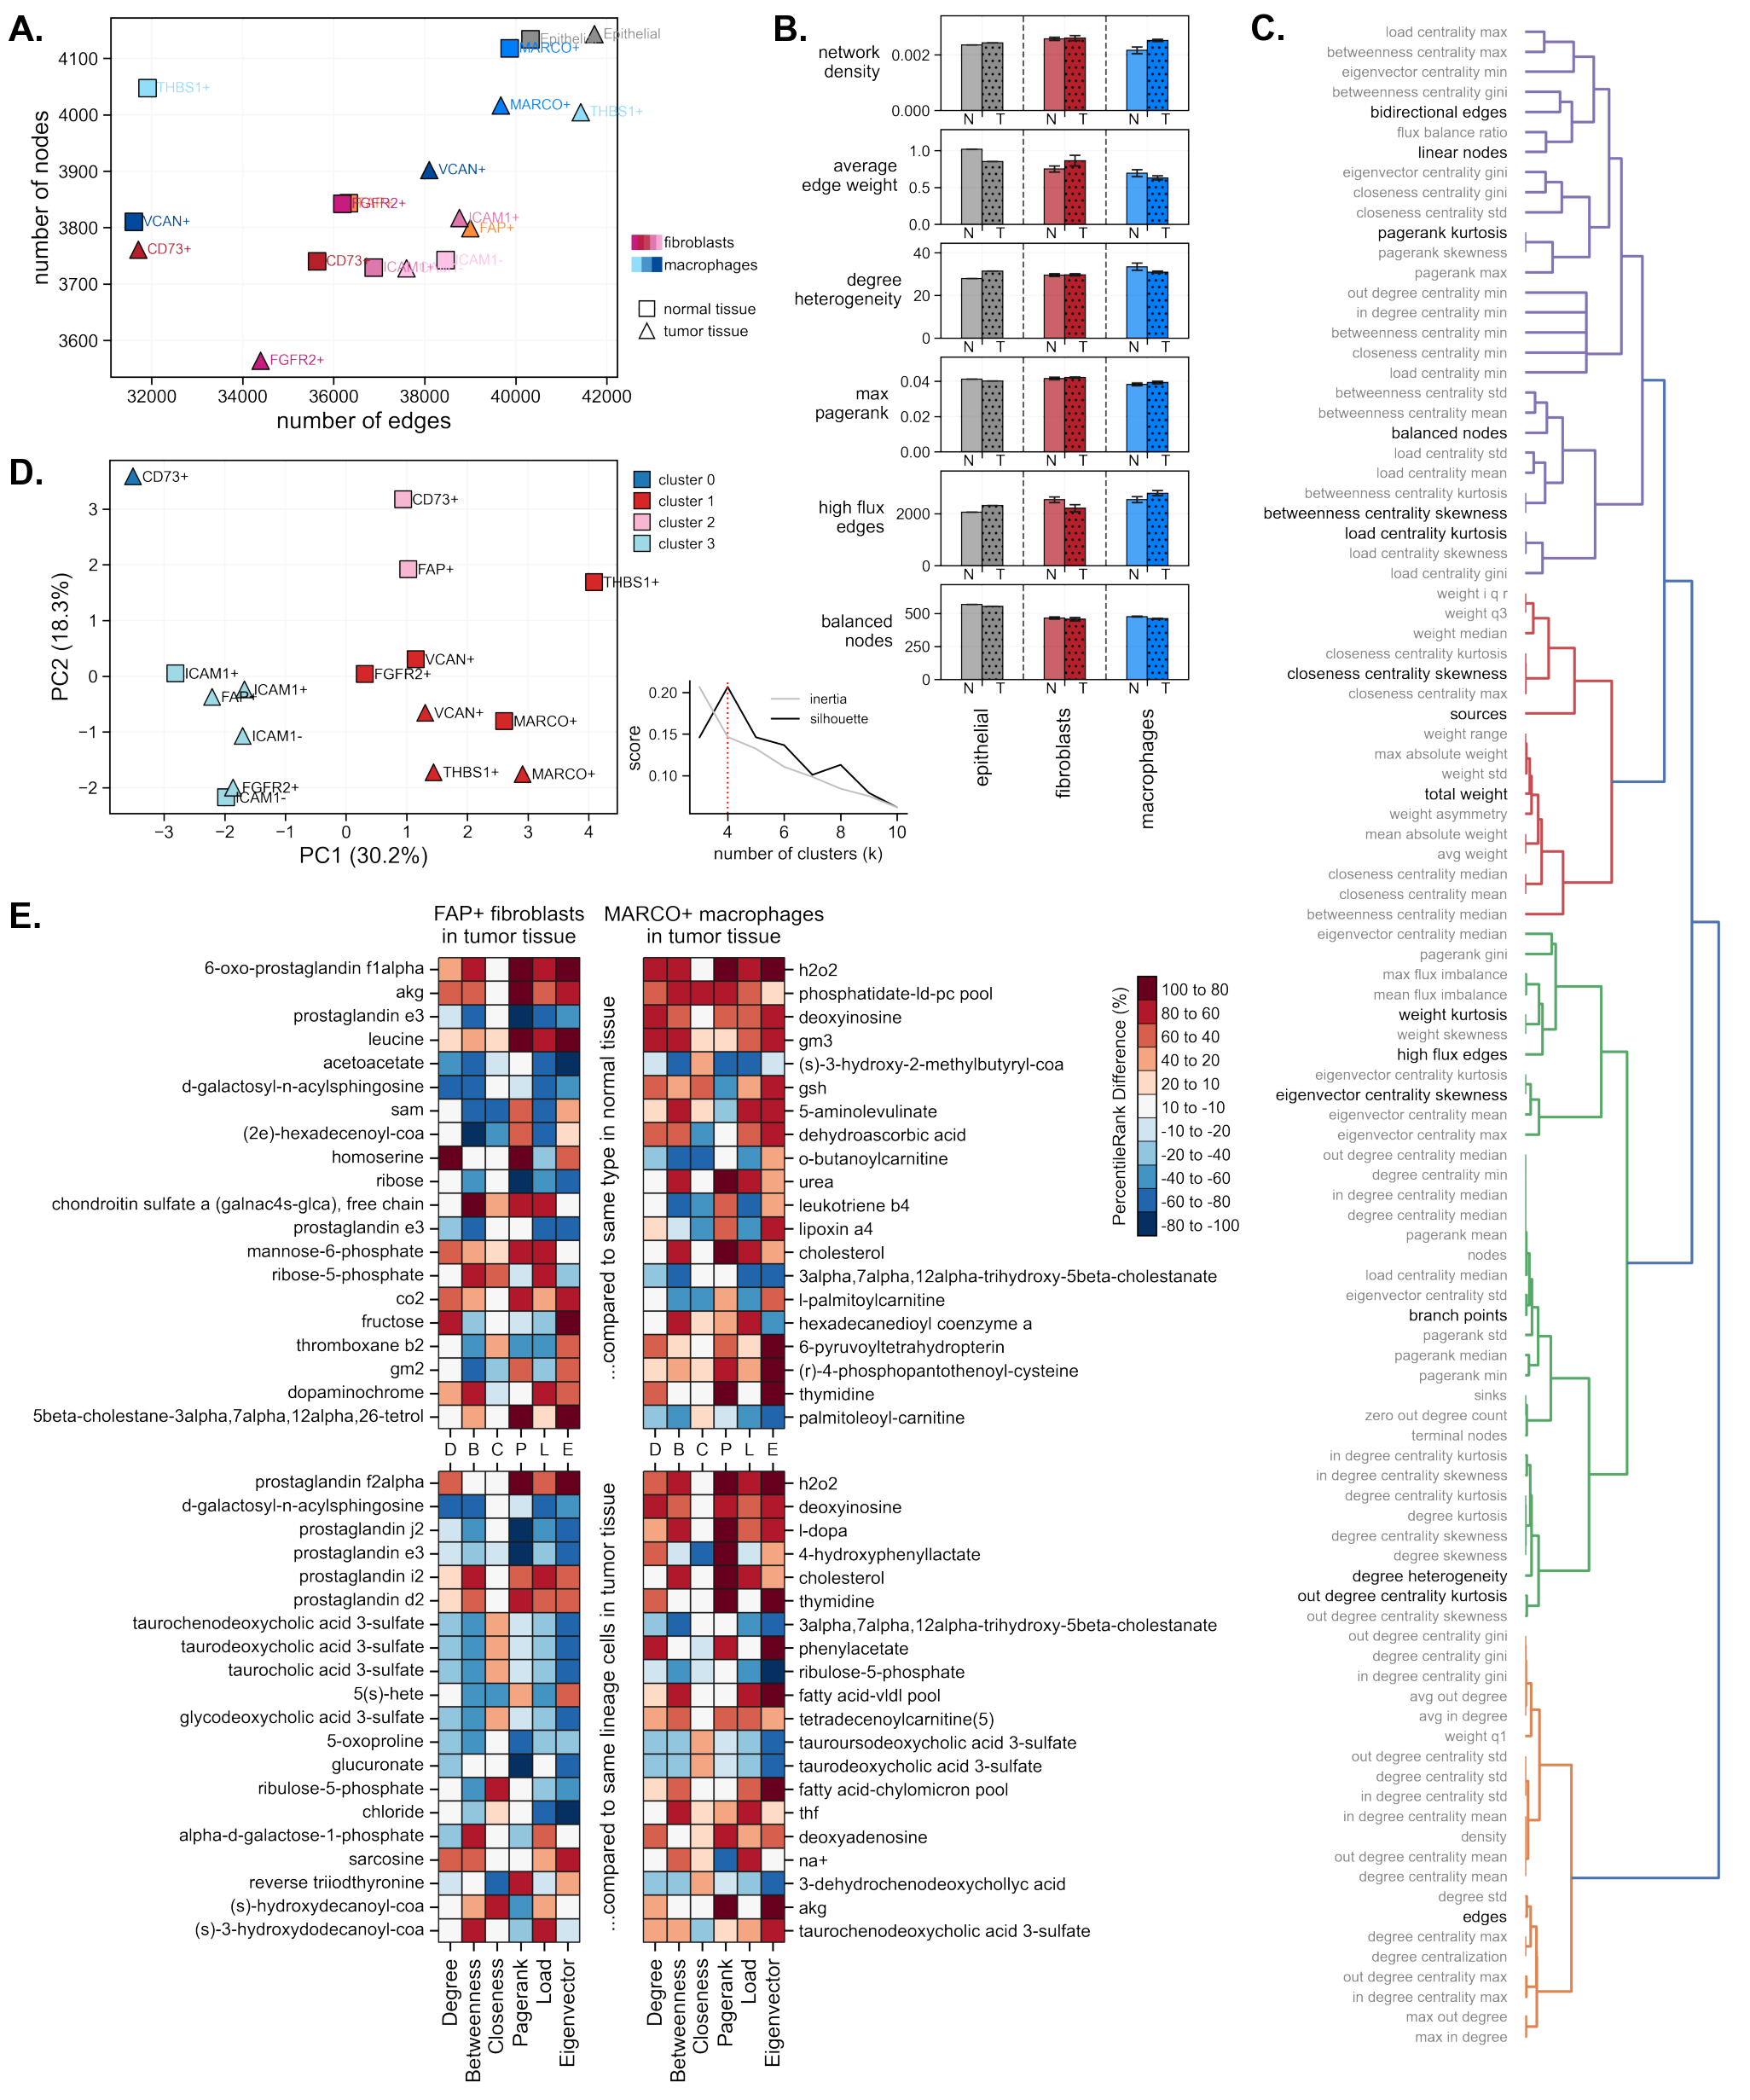

In [52]:
fig = plt.figure(figsize=(16, 16))
def add_panel(image_path, xyw, label=None, z=1):
    x, y, w = xyw
    # Read image to get aspect ratio
    img = mpimg.imread(image_path)
    img_h, img_w = img.shape[:2]
    aspect_ratio = img_h / img_w
    h = w * aspect_ratio  # scale height to keep image ratio
    bottom = 1 - y - h # Convert y from top-left origin to bottom-left origin
    ax = fig.add_axes([x, bottom, w, h], zorder=z)
    ax.imshow(img)
    ax.axis("off")
    if label:
        if label == "C":  x = 0.91
        if label == "D":  x = 0
        fig.text(x-0.01, bottom + h -0.005, label +'. ', fontsize=30, ha='left', va='top', fontweight='bold')

add_panel("../figures/png/figure4a_scatter_plot_graph_sizes.png", [0, 0, 0.55],    "A")
add_panel("../figures/png/figure4b_network_properties.png",       [0.56, 0, 0.3],  "B")
add_panel("../figures/png/figure4c_graph_metrics_dendrogram.png", [0.9, 0, 0.36],  "C") 
add_panel("../figures/png/figure4d_graph_metrics_clustering.png", [0.015, 0.325, 0.64], "D")
add_panel("../figures/png/figure4e_metabolite_rank_diff.png",     [0, 0.65, 0.9],  "E") 

if resave_figures: save_figure(fig, 'Figure4_Graph_Metrics')

Figure saved: SuppFig3_Topological_Features


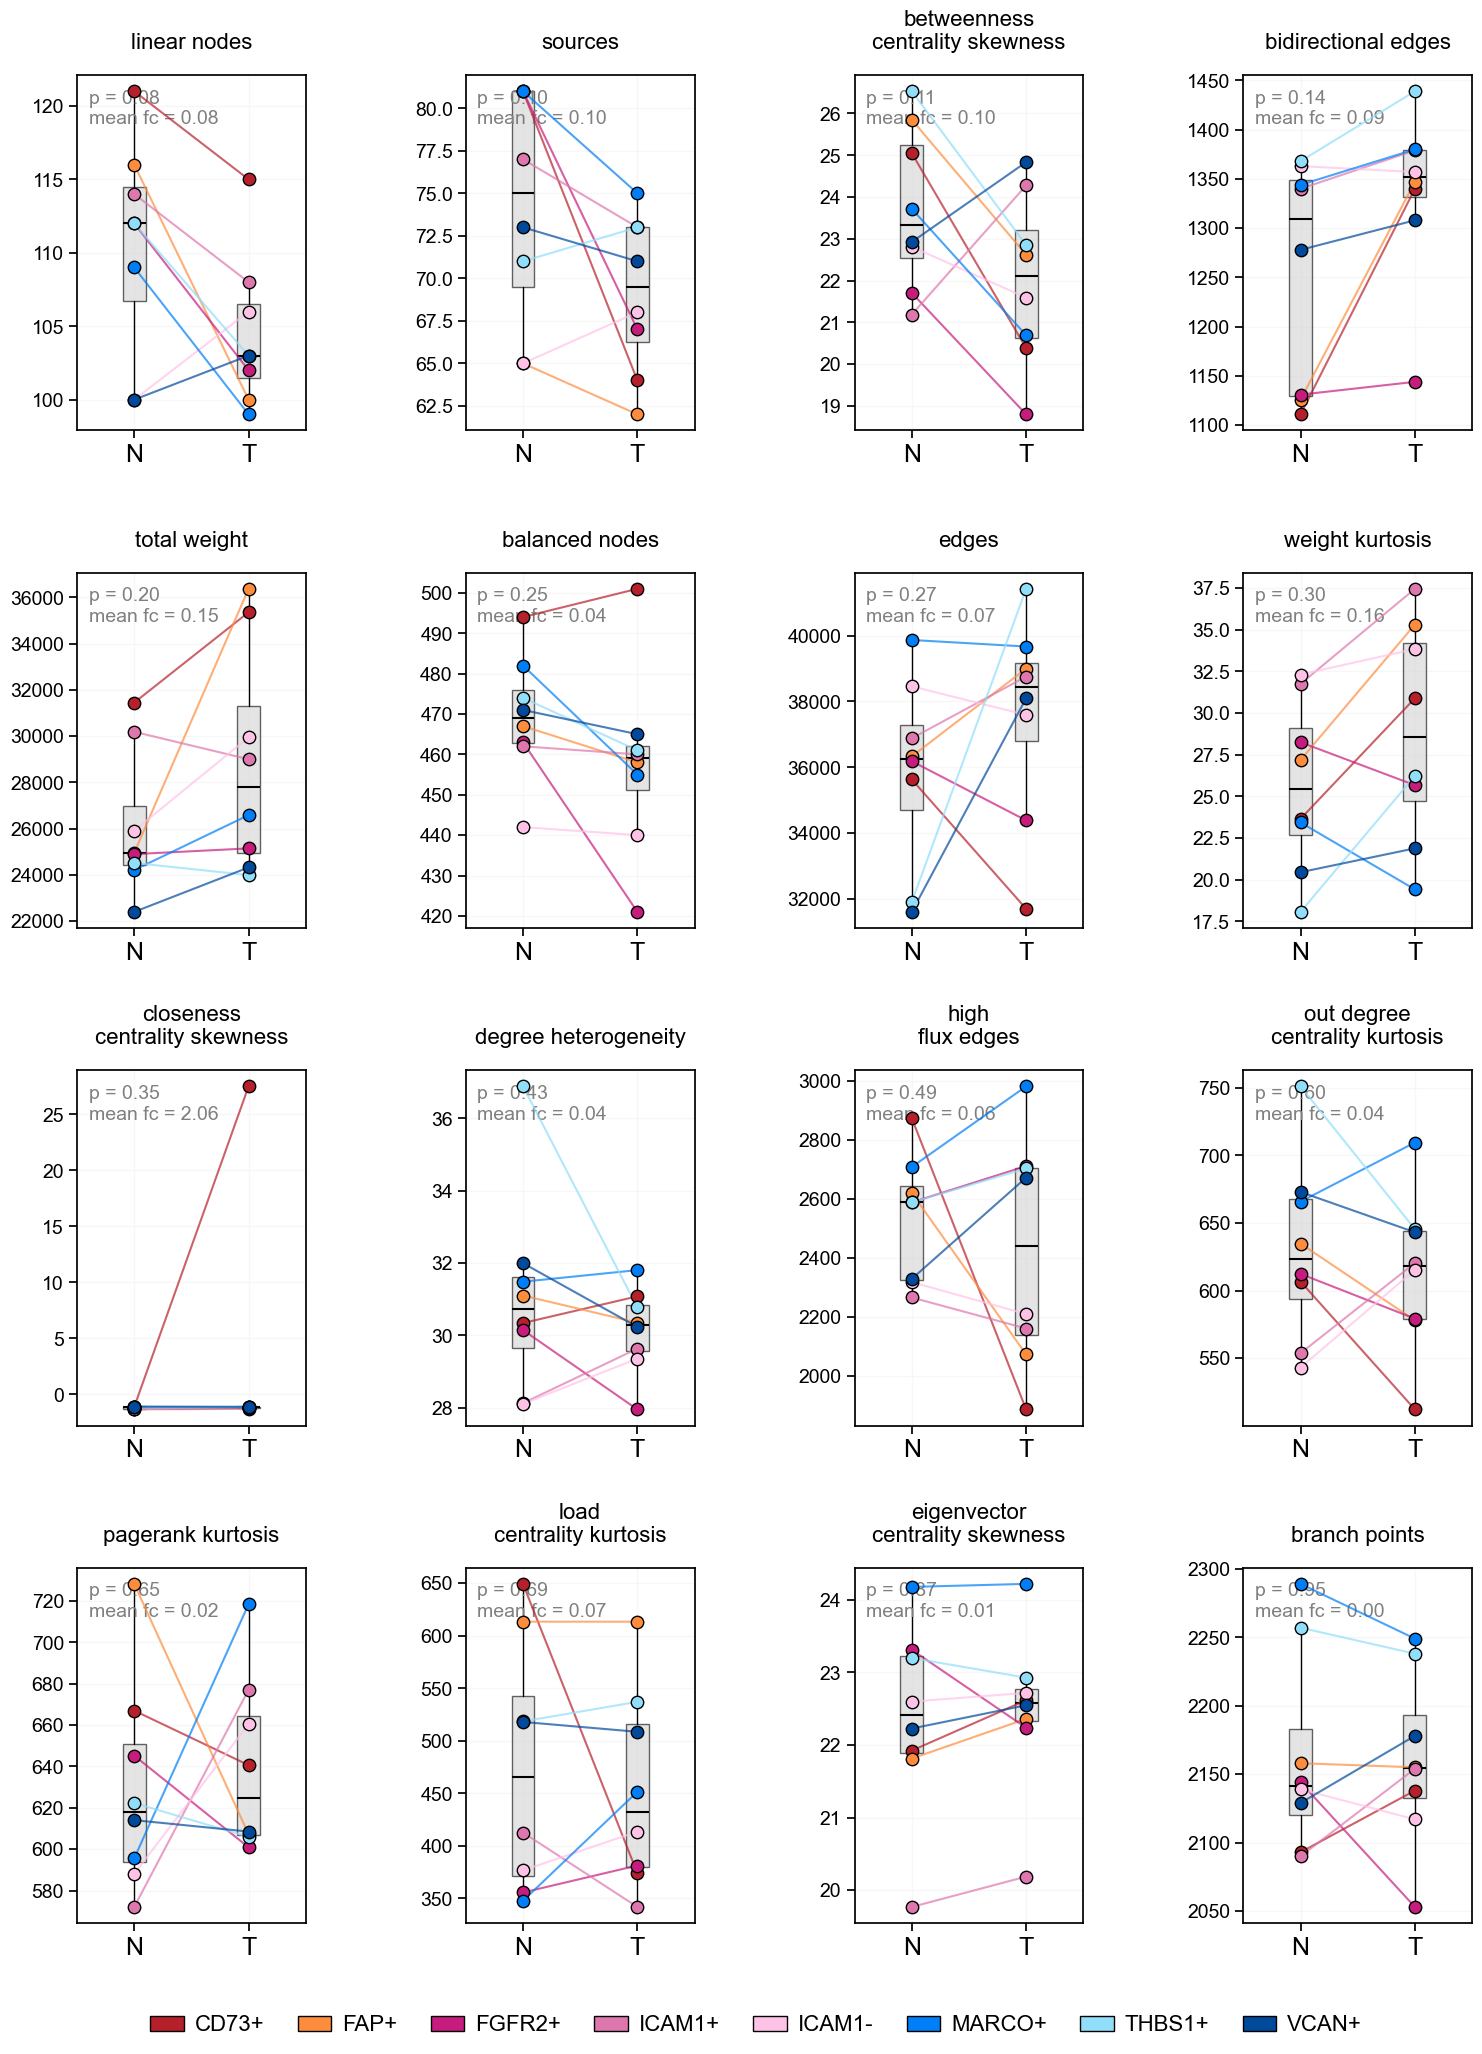

In [49]:

def calculate_fold_change(tumor_values, normal_values, offset=1.0): 
    # Find the minimum value to determine appropriate offset
    min_value = min(np.min(tumor_values), np.min(normal_values))
    
    # If minimum is negative, add offset to make all values positive
    if min_value < 0:
        # Add absolute min_value plus small additional value to ensure positivity
        offset = abs(min_value) + offset
        
    # Add offset to all values
    tumor_mean = np.mean(tumor_values) + offset
    normal_mean = np.mean(normal_values) + offset
    
    # Calculate log2 fold change
    fold_change = np.log2(tumor_mean / normal_mean)
    
    return np.abs(fold_change)


def showMetricsBoxesTvsN(df, marker_colors, metrics=None, n_cols=6, wspace=0.4, hspace=0.5, sig_threshold=0.05, figwidth=12, order_by_fold_change=True):
    
    # If no metrics are provided, use all numeric columns
    if metrics is None:
        metrics = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Get unique markers
    unique_markers = df['Marker'].unique()
    
    # Calculate fold changes for all metrics to enable sorting
    metricImportance = []
    
    for metric in metrics:
        # Prepare data for statistical tests
        normal_values = df[df['Tissue'] == 'Normal'][metric].values
        tumor_values = df[df['Tissue'] == 'Tumor'][metric].values
        
        try:
            # Calculate fold change (mean tumor / mean normal)
            fold_change = calculate_fold_change(tumor_values, normal_values)
 
            # Perform statistical test
            #stat, p_value = stats.mannwhitneyu(normal_values, tumor_values)
            stat, p_value = stats.ttest_ind(normal_values, tumor_values, equal_var=False)
            
            metricImportance.append({
                'metric': metric,
                'fold_change': fold_change,
                'p_value': p_value
            })
        except ValueError:
            # This happens if there's not enough data for the statistical test
            metricImportance.append({
                'metric': metric,
                'fold_change': np.nan,
                'p_value': np.nan
            })
    
    # Sort metrics by fold change if requested
    if order_by_fold_change:
        metricImportance.sort(key=lambda x: x['p_value'] if not np.isnan(x['p_value']) else -float('inf'), reverse=False)
    
    # Extract sorted metrics
    sorted_metrics = [item['metric'] for item in metricImportance]
    
    # Set up figure with subplots for each metric
    n_metrics = len(sorted_metrics)
    n_rows = int(np.ceil(n_metrics / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figwidth, 6 * n_rows))
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    axes = axes.flatten()
    
    # For each metric, create a plot
    for i, metric_info in enumerate(metricImportance):
        metric = metric_info['metric']
        fold_change = metric_info['fold_change']
        p_value = metric_info['p_value']
        
        ax = axes[i]
        
        # Group data by Marker and Tissue, and calculate mean for the metric
        grouped_data = df.groupby(['Marker', 'Tissue'])[metric].mean().reset_index()
        
        # Get tissue types (should be Normal and Tumor)
        tissues = df['Tissue'].unique()
        tissue_positions = {tissue: idx for idx, tissue in enumerate(tissues)}
        
        # Prepare data for boxplots
        normal_values = df[df['Tissue'] == 'Normal'][metric].values
        tumor_values = df[df['Tissue'] == 'Tumor'][metric].values
        
        # If the fold change and p-value were calculated successfully
        if not np.isnan(fold_change) and not np.isnan(p_value):
            # If p-value is below threshold, highlight the plot
            if p_value < sig_threshold:
                ax.text(0.05, .95, f'** Significant (p = {p_value:.2e})\nmean fc = {fold_change:.2f}',color='red', fontsize=14,
                        transform=ax.transAxes, ha='left', va='top')
            else:
                ax.text(0.05, .96, f'p = {p_value:.2f}\nmean fc = {fold_change:.2f}',  color='gray', fontsize=14,
                        transform=ax.transAxes, ha='left', va='top')
        else:
            # This happens if there's not enough data for the statistical test
            ax.text(0.05, .95, '\nInsufficient data\nfor statistics',
                   transform=ax.transAxes, ha='left', va='top')
        
        # Add a rank indicator if ordered by fold change
        title_fix = re.sub(r'(?<!^)(?=[A-Z])', ' ', str(metric)).lower()
        # if title_fix is 4 words or longer, split into two lines
        if len(title_fix.split()) >= 3:
            words = title_fix.split()
            mid = len(words) // 2
            title_fix = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])

        ax.set_title(title_fix, y=1.05, fontsize=16)
        
        # Add boxplots for Normal and Tumor - adjust position and width
        boxplot_positions = list(tissue_positions.values())
        boxplot_data = [normal_values, tumor_values]
        
        # Create box plots with partly transparent fill
        bp = ax.boxplot(boxplot_data, positions=boxplot_positions, widths=0.2, 
                       patch_artist=True, showfliers=False)
        
        # Set boxplot colors and transparency
        for box in bp['boxes']:
            box.set(facecolor='lightgray', alpha=0.6)
            box.set(edgecolor='black', linewidth=1)
        
        for whisker in bp['whiskers']:
            whisker.set(color='black', linewidth=1)
        
        for cap in bp['caps']:
            cap.set(color='black', linewidth=1)
        
        for median in bp['medians']:
            median.set(color='black', linewidth=1.5)
        
        # Plot each marker
        for marker in unique_markers:
            marker_data = grouped_data[grouped_data['Marker'] == marker]
            
            # Get x positions for the marker (one for each tissue)
            x_positions = [tissue_positions[tissue] for tissue in marker_data['Tissue']]
            
            # Plot the points
            color = marker_colors.get(marker, 'black')
            ax.scatter(x_positions, marker_data[metric],
                       color=color, s=80, 
                       label=marker, marker='o', 
                       edgecolor='black', zorder=10)  # Higher zorder to ensure points are on top
            
            # Connect the points with a line if both Normal and Tumor exist
            if len(x_positions) > 1:
                sort_idx = np.argsort(x_positions)
                ax.plot([x_positions[i] for i in sort_idx], 
                        [marker_data[metric].iloc[i] for i in sort_idx], 
                        color=color, linestyle='-', alpha=0.7, zorder=5)
        
        # Set up the axis
        ax.set_xticks(list(tissue_positions.values()))
        #ax.set_xticklabels(list(tissue_positions.keys()))
        ax.set_xticklabels(['N', 'T'], fontsize=18)
        ax.grid(True)
        
    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
     
    # Create legend at the bottom in one row
    legend_elements = []
    
    # Add marker legend entries
    for marker in unique_markers:
        if marker == 'Malignant': marker = 'Epithelial'
        legend_elements.append(Rectangle((0, 0), 1, 1,
                                     facecolor=marker_colors.get(marker, "#808080"),
                                     edgecolor='black',
                                     linewidth=1,
                                     label=marker))
    
    # Add legend at the bottom of the figure in one row
    fig.legend(handles=legend_elements,
               bbox_to_anchor=(.85, 0.08),
               ncol=10,  # All markers in one row
               frameon=False,
               fancybox=False,
               shadow=False,
               fontsize=16,
               edgecolor='black',
               facecolor='white',
               columnspacing=1.5,
               handlelength=1.5,
               handletextpad=0.5)
    
    
    #plt.tight_layout()
    plt.subplots_adjust(wspace=0.7, hspace=0.4)
 
    if resave_figures: save_figure(fig, 'SuppFig3_Topological_Features')
    plt.show()

    # Return the sorted metrics with fold changes for further analysis
    return metricImportance

# More stringent threshold (p < 0.01)
metricImportance = showMetricsBoxesTvsN(G_metrics_filtered, marker_colors, n_cols=4, sig_threshold=0.01, figwidth=18)